In [1]:
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datasets import load_dataset,concatenate_datasets
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
def filter_data(data, metric_name, metric_value):    
    if metric_name == 'degree':
        p_id = data.filter(lambda x: ((x['label']==1) & (x['min_angle']<=metric_value)))
        p_ood = data.filter(lambda x: ((x['label']==1) & (x['min_angle']>metric_value)))        
        n_id = data.filter(lambda x: ((x['label']==0) & (x['min_angle']>metric_value)))
        n_ood = data.filter(lambda x: ((x['label']==0) & (x['min_angle']<=metric_value)))
        id_data=concatenate_datasets([p_id,n_id])
        ood_data=concatenate_datasets([p_ood,n_ood])        
    elif metric_name == 'area':
        p_id = data.filter(lambda x: ((x['label']==1) & (x['max_area']>=metric_value)))
        p_ood = data.filter(lambda x: ((x['label']==1) & (x['max_area']<metric_value)))        
        n_id = data.filter(lambda x: ((x['label']==0) & (x['max_area']<metric_value)))
        n_ood = data.filter(lambda x: ((x['label']==0) & (x['max_area']>=metric_value)))        
        id_data=concatenate_datasets([p_id,n_id])
        ood_data=concatenate_datasets([p_ood,n_ood])    
    return id_data, ood_data

In [3]:
def metric_calculation(data):
    gt=data['label']
    pred=data['pred']
    acc=accuracy_score(gt, pred)
    _,fpc,fnc,_=confusion_matrix(gt, pred).ravel()
    fpr=fpc/len(data)
    fnr=fnc/len(data)
    return acc,fpr,fnr

In [14]:
def post_processing(data, model, metric_name, metric_value):
    
    ## load ground truth & predictions
    gt=np.array(data['label'])
    if model == 'heuristic':
        if metric_name=='degree':
            pred=np.array(data['min_angle'])<=metric_value
        elif metric_name == 'distance':
            pred=np.array(data['euc_dist'])>=metric_value
    elif model == 'bert':
        pred=np.load(f'{metric_name}/{model}_{metric_name}_{metric_value}_generalization.npy')        
    else:
        pred=np.load(f'{metric_name}/{model}_{metric_name}_{metric_value}_generalization.npy')
        pred=np.array([int(i.replace('<|eot_id|>', '')\
                           .replace('</s>', '')\
                           .split('Label:')[1]\
                           .strip()) for i in pred])        
    data=data.add_column("pred", pred)
    id_data, ood_data=filter_data(data, metric_name, metric_value)
    
    return data,id_data,ood_data

In [15]:
ds = load_dataset("beanham/spatial_union_dataset")
test=ds['test']

In [16]:
metric_name='degree'
models=['heuristic','llama3', 'mistral', '4o_mini']
metric_values=[1,2,5,10,20]
degree_results=[]
for model in models:
    for metric_value in metric_values:
        data,id_data,ood_data=post_processing(test,model,metric_name,metric_value)
        acc,fpr,fnr=metric_calculation(data)
        id_acc,_,_=metric_calculation(id_data)
        ood_acc,_,_=metric_calculation(ood_data)
        degree_results.append([model, metric_name, metric_value, acc,fpr,fnr,len(id_data),id_acc,len(ood_data),ood_acc])
degree_results=pd.DataFrame(degree_results, columns=['model','metric','metric_value','acc','fpr','fnr','id_count','id_acc','ood_count','ood_acc'])
degree_results['total_count']=[len(test)]*len(degree_results)
degree_results['id_correct_count']=degree_results.id_count.values*degree_results.id_acc.values
degree_results['ood_correct_count']=degree_results.ood_count.values*degree_results.ood_acc.values

# Area

In [18]:
def post_processing(data, model, metric_name, metric_value):
    
    ## load ground truth & predictions
    gt=np.array(data['label'])
    if model == 'heuristic':
        if metric_name=='degree':
            pred=np.array(data['min_angle'])<=metric_value
        elif metric_name == 'distance':
            pred=np.array(data['euc_dist'])>=metric_value
    elif model == 'bert':
        pred=np.load(f'{metric_name}/{model}_{metric_name}_{metric_value}_generalization.npy')        
    else:
        pred=np.load(f'{metric_name}/{model}_{metric_name}_{metric_value}_generalization.npy')
        pred=np.array([int(i.replace('<|eot_id|>', '')\
                           .replace('</s>', '')\
                           .split('Label:')[1]\
                           .strip()) for i in pred])        
    data=data.add_column("pred", pred)
    id_data, ood_data=filter_data(data, 'area', metric_value)
    
    return data,id_data,ood_data

In [19]:
models=['heuristic','llama3','mistral', '4o_mini']
metric_name='distance'
metric_values=[1,2,3,4,5]
distance_results=[]
for model in models:
    for metric_value in metric_values:
        data,id_data,ood_data=post_processing(test,model,metric_name,metric_value)
        acc,fpr,fnr=metric_calculation(data)        
        distance_results.append([model, metric_name, metric_value, acc,fpr,fnr])
distance_results=pd.DataFrame(distance_results, columns=['model','metric','metric_value','acc','fpr','fnr'])
distance_results['total_count']=[len(test)]*len(distance_results)

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

In [76]:
names=['min_angle (union)']*15+['max_area (union)']*15+['min_angle (join)']*15+['min_distance (join)']*15
models=(['llama3']*5+['mistral']*5+['4o_mini']*5)*4
acc=[0.870, 0.855, 0.827, 0.867, 0.845,
     0.807, 0.855, 0.857, 0.872, 0.862,
     0.945, 0.897, 0.922, 0.917, 0.897,
     0.845, 0.892, 0.882, 0.860, 0.890,
     0.897, 0.900, 0.905, 0.915, 0.887,
     0.955, 0.955, 0.970, 0.960, 0.952,
     0.874687, 0.884712, 0.899749, 0.867168, 0.872180,
     0.904762, 0.899749, 0.874687, 0.887218, 0.884712,
     0.904762, 0.917293,0.902256, 0.892231, 0.882206,
     0.829574, 0.774436, 0.819549, 0.83208, 0.864662,
     0.857143, 0.824561, 0.884712, 0.857143, 0.882206,
     0.892231, 0.819549, 0.844612, 0.899749, 0.847118]
vis_data=pd.DataFrame(np.c_[names,models,acc], columns=['heuristics', 'models', 'accuracy'])
vis_data = vis_data.astype({"accuracy": float})

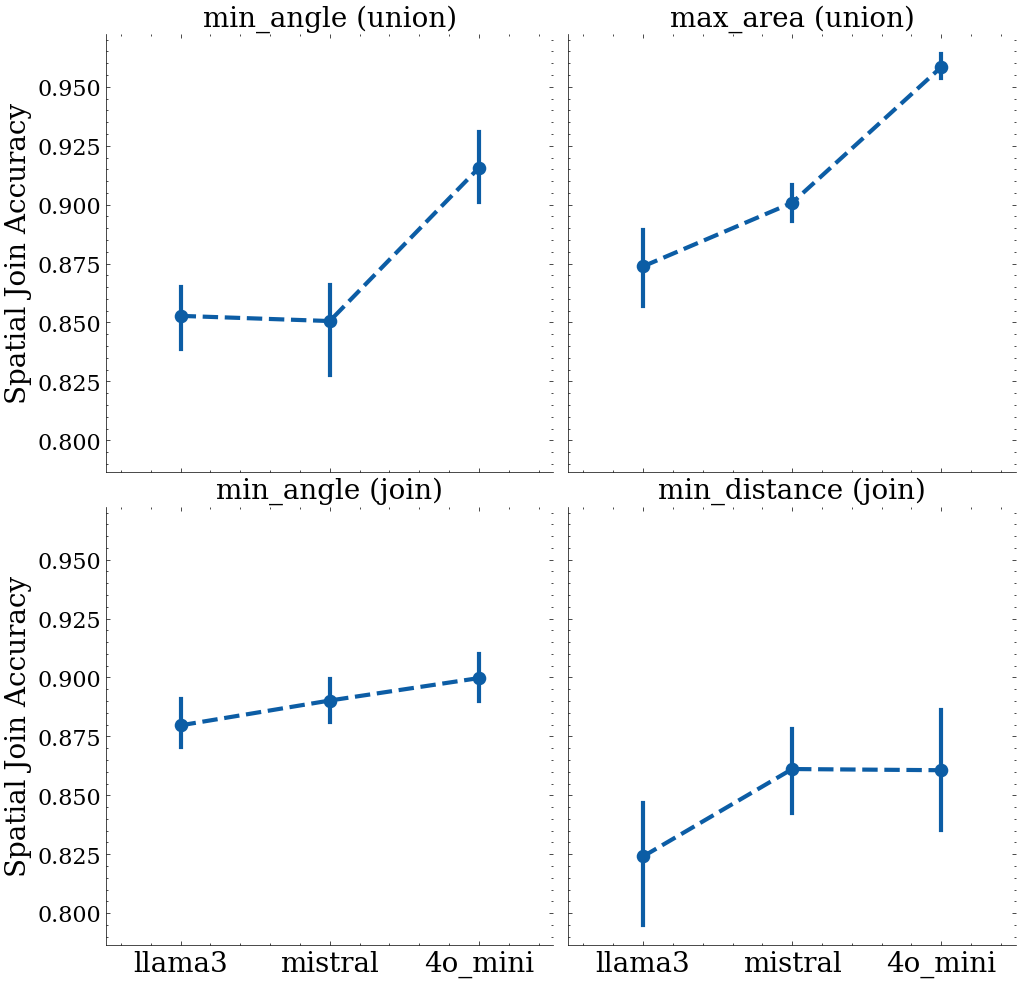

In [111]:
plt.style.use('science')
plt.rc('text', usetex=False)
plot=sns.catplot(vis_data, kind="point", x="models", y="accuracy", col="heuristics", col_wrap=2,linestyle='--', linewidth=3)
plot.set_titles(col_template="{col_name}", size=20)
plot.set_xlabels("")
plot.set_ylabels("Spatial Join Accuracy", fontsize=20)
plot.tick_params(axis='y', labelsize=16)
plot.tick_params(axis='x', labelsize=20)
#plt.savefig(f"../../misc/union_task_generalization.png", bbox_inches='tight',pad_inches=0, dpi=600)
pass